### Import libraries

In [655]:
# !pip install xgboost

In [656]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

import pickle
import os
from datetime import datetime

### Import data

In [657]:
df = pd.read_csv('/workspaces/heart-disease-prediction-system/data/heart_disease_uci.csv')
df.sample(3)

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
569,570,53,Male,Hungary,asymptomatic,180.0,285.0,False,st-t abnormality,120.0,True,1.5,flat,NaN,NaN,1
250,251,57,Male,Cleveland,asymptomatic,110.0,201.0,False,normal,126.0,True,1.5,flat,0.0,fixed defect,0
476,477,57,Male,Hungary,atypical angina,140.0,260.0,True,normal,140.0,False,0.0,NaN,NaN,fixed defect,0


In [658]:
df['target'] = (df.num>0).astype(int)
del df['num']

In [659]:
print("\n" + "="*50)
print("DATA QUALITY CHECKS")
print("="*50)

print("Missing values in each column:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "No missing values found!")

duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

print(f"\nData types:\n{df.dtypes}")

print("\nDescriptive statistics:")
display(df.describe().T)


DATA QUALITY CHECKS
Missing values in each column:
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
dtype: int64
Number of duplicate rows: 0

Data types:
id            int64
age           int64
sex          object
dataset      object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
target        int64
dtype: object

Descriptive statistics:


,count,mean,std,min,25%,50%,75%,max
id,920.0,460.500000,265.725422,1.0,230.75,460.5,690.25,920.0
age,920.0,53.510870,9.424685,28.0,47.00,54.0,60.00,77.0
trestbps,861.0,132.132404,19.066070,0.0,120.00,130.0,140.00,200.0
chol,890.0,199.130337,110.780810,0.0,175.00,223.0,268.00,603.0
thalch,865.0,137.545665,25.926276,60.0,120.00,140.0,157.00,202.0
oldpeak,858.0,0.878788,1.091226,-2.6,0.00,0.5,1.50,6.2
ca,309.0,0.676375,0.935653,0.0,0.00,0.0,1.00,3.0
target,920.0,0.553261,0.497426,0.0,0.00,1.0,1.00,1.0


### EDA

In [660]:
def check_null_columns(data_frame):
    return data_frame.isnull().sum()

In [661]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  target    920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


##### checking target variable

In [662]:
df.target.value_counts(normalize=True)

target
1    0.553261
0    0.446739
Name: proportion, dtype: float64

/tmp/ipykernel_2113/555499215.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='target', palette=['lightblue', 'lightcoral'])


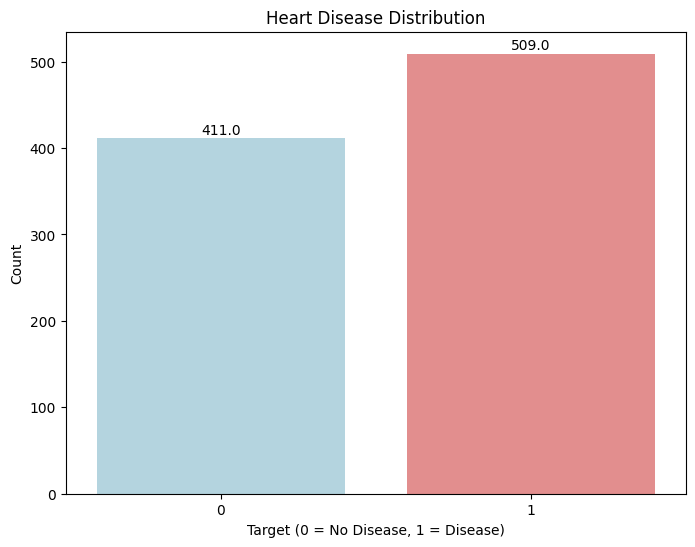

In [663]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='target', palette=['lightblue', 'lightcoral'])
plt.title('Heart Disease Distribution')
plt.xlabel('Target (0 = No Disease, 1 = Disease)')
plt.ylabel('Count')

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height() + 1, 
            f'{p.get_height()}', ha='center', va='bottom')

plt.show()


##### dealing with numerical and categorical columns

In [664]:
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
categorical_columns

['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [665]:
numerical_columns = [col for col in list(df.dtypes[df.dtypes!="object"].index) if col not in {"id","target"}]
numerical_columns

['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

##### checking if there are missing values

In [666]:
check_null_columns(df)

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

##### fill missing value for numerical columns with median value

In [667]:
for col in numerical_columns:
    df[col] = df[col].fillna(df[col].median())

##### fill missing value for categorical columns with mode

In [668]:
for col in categorical_columns:
    df[col] = df[col].fillna(df[col].mode()[0])

/tmp/ipykernel_2113/3475143349.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])


In [669]:
check_null_columns(df)

id          0
age         0
sex         0
dataset     0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Prepare train, tets, val datasets

In [670]:
df_full_train, df_test = train_test_split(df,test_size=0.2,random_state=1)
len(df_full_train), len(df_test)

df_train, df_val = train_test_split(df_full_train, test_size=0.25,random_state=1)
len(df_train), len(df_val)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.target.values
y_val = df_val.target.values
y_test = df_test.target.values

del df_train['target']
del df_val['target']
del df_test['target']

##### Train Models

##### creating dict that will store all trained models to select the best one

In [671]:
trained_models = {}

##### Logistic Regression

In [672]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [673]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

X_val_scaled = scaler.transform(X_val)

y_pred = model.predict_proba(X_val_scaled)[:, 1]


In [674]:
roc_auc_score(y_val, y_pred)

0.8820976491862568

In [675]:
fpr,tpr,thresholds = roc_curve(y_val,y_pred)

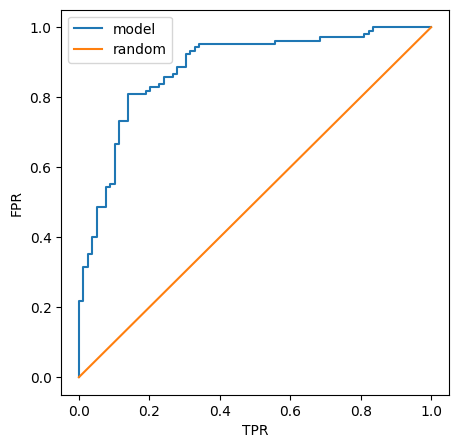

In [676]:
plt.figure(figsize=(5,5))
plt.plot(fpr,tpr,label='model')
plt.plot([0,1],[0,1],label = 'random')
plt.ylabel('FPR')
plt.xlabel('TPR')
plt.legend()

In [677]:
auc(fpr,tpr)

0.8820976491862568

In [678]:
y_pred_hard = model.predict(X_val_scaled)
confusion_matrix(y_val,y_pred_hard)

array([[65, 14],
       [20, 85]])

In [679]:
print(classification_report(y_val, y_pred_hard))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79        79
           1       0.86      0.81      0.83       105

    accuracy                           0.82       184
   macro avg       0.81      0.82      0.81       184
weighted avg       0.82      0.82      0.82       184



In [680]:
trained_models['LogisticRegression'] = roc_auc_score(y_val, y_pred)

##### DecisionTreeClassifier

In [681]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [682]:
val_dict = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.6799276672694394

In [683]:
scores = []
for d in [3,4,5,6,7,10,15,20,None]:
    for s in [1,2,5,10,20,100,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred =dt.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,s,auc))

In [684]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
df_scores.sort_values(by='auc', ascending=False)

,max_depth,min_samples_leaf,auc
9,4.0,5,0.837131
3,3.0,10,0.829355
5,3.0,100,0.823749
12,4.0,100,0.823749
19,5.0,100,0.823749
...,...,...,...
34,7.0,500,0.500000
41,10.0,500,0.500000
48,15.0,500,0.500000
55,20.0,500,0.500000


In [685]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns='max_depth', values='auc')

df_scores_pivot.round(3)

max_depth,NaN,3.0,4.0,5.0,6.0,7.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,,
1,0.689,0.815,0.796,0.777,0.753,0.722,0.718,0.682,0.656
2,0.709,0.815,0.813,0.780,0.775,0.735,0.753,0.720,0.723
5,0.780,0.823,0.837,0.811,0.792,0.796,0.787,0.779,0.766
10,0.762,0.829,0.792,0.795,0.766,0.767,0.761,0.762,0.759
20,0.812,0.802,0.806,0.816,0.812,0.812,0.812,0.812,0.812
100,0.824,0.824,0.824,0.824,0.824,0.824,0.824,0.824,0.824
500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500,0.500


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

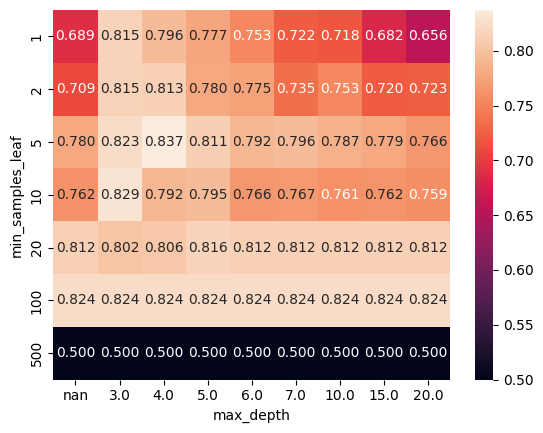

In [686]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

##### the best DecisionTreeClassifier model

In [687]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5)
dt.fit(X_train, y_train)

y_pred =dt.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8371308016877638

In [688]:
trained_models['DecisionTreeClassifier'] = roc_auc_score(y_val, y_pred)

##### Ensemble Learning and Random Forest

In [689]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [690]:
y_pred = rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8595539481615431

In [691]:
scores = []
for n in range(10,201,10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred= rf.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, y_pred)
    scores.append((n,auc))

Text(0, 0.5, 'AUC')

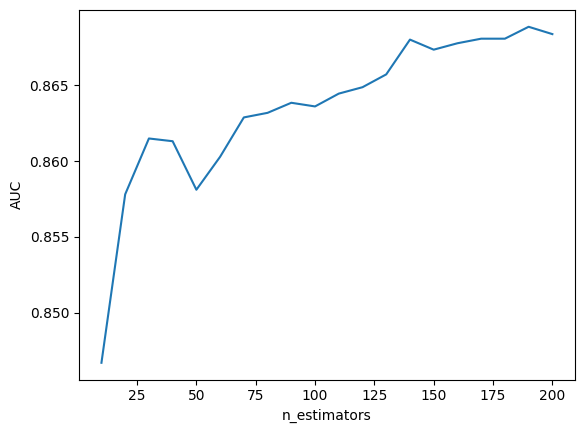

In [692]:
scores_rf = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(scores_rf.n_estimators, scores_rf.auc)
plt.xlabel('n_estimators')
plt.ylabel('AUC')

In [693]:
scores = []
for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=d, random_state=1)
        rf.fit(X_train, y_train)

        y_pred= rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d,n,auc))

In [694]:
scores_rf = pd.DataFrame(scores, columns=['max_depth','n_estimators', 'auc'])
scores_rf.head()

,max_depth,n_estimators,auc
0,5,10,0.867511
1,5,20,0.872694
2,5,30,0.881857
3,5,40,0.881495
4,5,50,0.884750


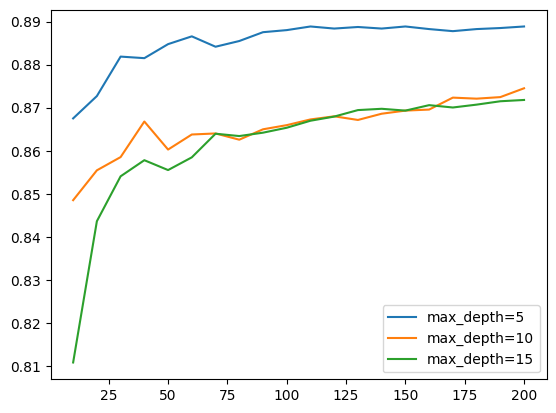

In [695]:
for d in [5,10,15]:
    df_subset = scores_rf[scores_rf['max_depth']==d]    
    plt.plot(df_subset.n_estimators, df_subset.auc,label=f'max_depth={d}')
plt.legend()

In [696]:
max_depth = 5

In [697]:
scores = []
for s in [1,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n,max_depth=max_depth,min_samples_leaf=s, random_state=1)
        rf.fit(X_train, y_train)

        y_pred= rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s,n,auc))

In [698]:
scores_rf = pd.DataFrame(scores, columns=['min_samples_leaf','n_estimators', 'auc'])
scores_rf.head()

,min_samples_leaf,n_estimators,auc
0,1,10,0.867511
1,1,20,0.872694
2,1,30,0.881857
3,1,40,0.881495
4,1,50,0.884750


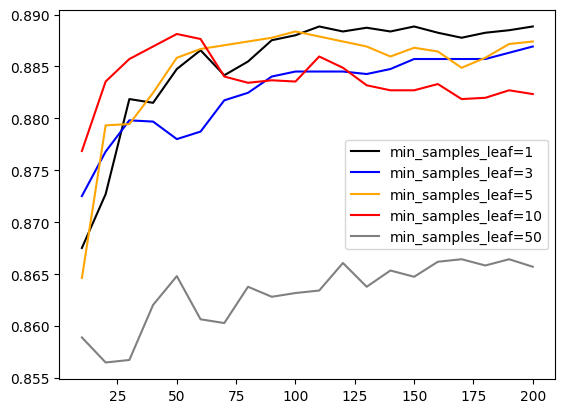

In [699]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
min_samples_leaf=[1,3,5,10,50]
for s,col in zip(min_samples_leaf, colors):
    df_subset = scores_rf[scores_rf['min_samples_leaf']==s]    
    plt.plot(df_subset.n_estimators, df_subset.auc,label=f'min_samples_leaf={s}',color=col)
plt.legend()

In [700]:
min_samples_leaf = 1

##### the best RandomForestClassifier model

In [701]:
rf = RandomForestClassifier(n_estimators=100,max_depth=max_depth,min_samples_leaf=min_samples_leaf, random_state=1,n_jobs=-1)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [702]:
y_pred =rf.predict_proba(X_val)[:,1]
roc_auc_score(y_val, y_pred)

0.8880048221820374

In [703]:
trained_models['RandomForestClassifier'] = roc_auc_score(y_val, y_pred)

##### Gradient Boosting and XGBoost

In [704]:
features = dv.get_feature_names_out()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features.tolist())
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features.tolist())

In [705]:
watchlist = [(dtrain, 'train'), (dval, 'eval')]

In [706]:
%%capture output
xgb_params = {
    'eta':0.3,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=200)

In [707]:
def parse_xgb_output(output):
    results = []
    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    columns=['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [708]:
df_score = parse_xgb_output(output)

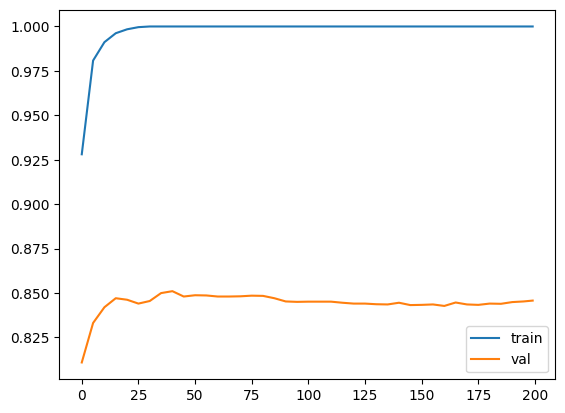

In [709]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

In [710]:
y_pred =model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8456901748040988

##### XGBoost Parameter Tuning

In [711]:
scores = {}

In [712]:
%%capture output
xgb_params = {
    'eta':0.05,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=200)

In [713]:
key = f'eta={xgb_params["eta"]}'
scores[key] = parse_xgb_output(output)

In [714]:
scores.keys()

dict_keys(['eta=0.05'])

In [715]:
etas = [ 'eta=0.1', 'eta=0.05', 'eta=0.01']

for eta in etas:
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_auc, label=eta)
plt.legend()

KeyError: 'eta=0.1'

In [ ]:
scores = {}

In [ ]:
%%capture output
xgb_params = {
    'eta':0.1,
    'max_depth':10,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=200)

In [ ]:
key = f'max_depth={xgb_params["max_depth"]}'
scores[key] = parse_xgb_output(output)

In [ ]:
scores.keys()

dict_keys(['max_depth=6', 'max_depth=3', 'max_depth=4', 'max_depth=10'])

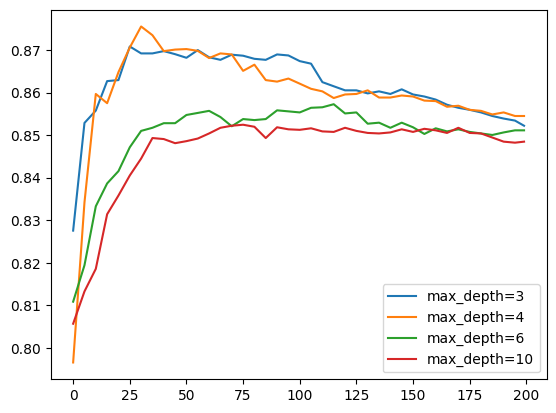

In [ ]:
max_depths = ['max_depth=3', 'max_depth=4', 'max_depth=6', 'max_depth=10']

for max_depth in max_depths:
    df_score = scores[max_depth]
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)
plt.legend()

In [ ]:
scores = {}

In [ ]:
%%capture output
xgb_params = {
    'eta':0.1,
    'max_depth':4,
    'min_child_weight':1,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=200)

In [ ]:
key = f'min_child_weight={xgb_params["min_child_weight"]}'
scores[key] = parse_xgb_output(output)

In [ ]:
scores.keys()

dict_keys(['min_child_weight=30', 'min_child_weight=10', 'min_child_weight=1'])

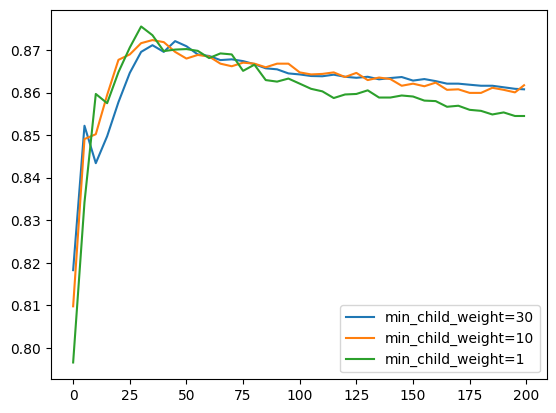

In [ ]:
for min_child_weight,df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)
plt.legend()

In [ ]:
%%capture output
xgb_params = {
    'eta':0.1,
    'max_depth':4,
    'min_child_weight':10,
    'objective':'binary:logistic',
    'eval_metric':'auc',
    'nthread':8,
    'seed':1,
    'verbosty':1
}
model = xgb.train(xgb_params, dtrain,verbose_eval=5,evals=watchlist, num_boost_round=50)

In [ ]:
y_pred =model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8675105485232067

In [ ]:
trained_models['xgb'] = roc_auc_score(y_val, y_pred)

##### Selecting the final model

In [ ]:
trained_models

{'LogisticRegression': 0.8820976491862568,
 'DecisionTreeClassifier': 0.8371308016877638,
 'RandomForestClassifier': 0.8880048221820374,
 'xgb': 0.8675105485232067}

##### train final model

In [723]:
df_full_train = df_full_train.reset_index(drop=True)

y_full_train = df_full_train.target.values

del df_full_train['target']

In [724]:
dicts_full_train = df_full_train[categorical_columns + numerical_columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [725]:
dicts_test = df_test[categorical_columns + numerical_columns].to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [726]:
rf = RandomForestClassifier(n_estimators=100,max_depth=5,min_samples_leaf=1, random_state=1,n_jobs=-1)
rf.fit(X_full_train, y_full_train)

,n_estimators,100
,criterion,'gini'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [727]:
y_pred =rf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_pred)

0.9139240506329114

### Saving the best trained model

In [728]:
os.makedirs('../models', exist_ok=True)

In [729]:
output_file = f'../models/random_forest_heart_disease_v1.bin'

In [730]:
with open(output_file,'wb') as f_out:
    pickle.dump((dv,rf),f_out)

##### load the model

In [731]:
model_file = f'/workspaces/heart-disease-prediction-system/models/random_forest_heart_disease_v1.bin'

In [732]:
with open(model_file,'rb') as f_in:
   dv,rf = pickle.load(f_in)

In [734]:
dv, rf

(DictVectorizer(sparse=False),
 RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=1))

In [745]:
cols = list(df.columns[(df.columns != 'id') & (df.columns != 'target')])

In [761]:
#patient =  df[cols].sample().to_dict(orient='records')
df[cols].sample().to_dict(orient='records')

[{'age': 38,
  'sex': 'Male',
  'dataset': 'Hungary',
  'cp': 'asymptomatic',
  'trestbps': 110.0,
  'chol': 196.0,
  'fbs': False,
  'restecg': 'normal',
  'thalch': 166.0,
  'exang': False,
  'oldpeak': 0.0,
  'slope': 'flat',
  'ca': 0.0,
  'thal': 'normal'}]

In [762]:
patient = {
  'age': 57,
  'sex': 'Male',
  'dataset': 'Cleveland',
  'cp': 'non-anginal',
  'trestbps': 110.0,
  'chol': 260.0,
  'fbs': False,
  'restecg': 'lv hypertrophy',
  'thalch': 151.0,
  'exang': False,
  'oldpeak': 0.1,
  'slope': 'upsloping',
  'ca': 0.0,
  'thal': 'normal'
}

In [763]:

X = dv.transform([patient])

In [764]:
rf.predict_proba(X)[0,1]

np.float64(0.3057704732113773)